# Regularization

1. [L2 regularization](#l2)
2. [Dropout regularization](#dropout)



|               Model               | Training error | Test error |
| :-------------------------------: | :------------: | :--------: |
| 3-layer NN without regularization |      95%       |   91.5%    |
| 3-layer NN with L2-regularization |      94%       |    93%     |
|      3-layer NN with dropout      |      93%       |    95%     |

---------
<font color='blue'>
**Takeaways**:
- Regularization will help you reduce overfitting.
- Regularization will drive your weights to lower values.
- L2 regularization and Dropout are two very effective regularization techniques.

## 0 -  Load Packages and Dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from reg_utils import *
import sklearn
import sklearn.datasets
import scipy.io

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

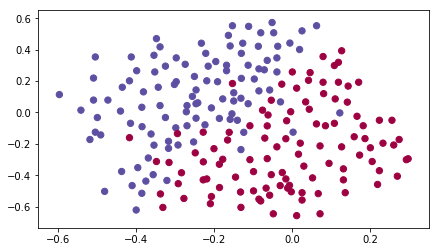

In [3]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

## 1- Model

It is possible to use both L2 regularization and dropout, but this assignment will only explore one at a time.

In [4]:
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 1):
    """
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (output size, number of examples)
    learning_rate -- learning rate of the optimization
    num_iterations -- number of iterations of the optimization loop
    print_cost -- If True, print the cost every 10000 iterations
    lambd -- regularization hyperparameter, scalar
    keep_prob - probability of keeping a neuron active during drop-out, scalar.
    
    Returns:
    parameters -- parameters learned by the model. They can then be used to predict.
    """
    costs = []                            # to keep track of the cost
    m = X.shape[1]                        # number of examples
    layers_dims = [X.shape[0], 20, 3, 1]
    L = len(layers_dims) - 1
    
    # Initialize parameters dictionary.
    parameters = initialize_parameters(layers_dims)

    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        if keep_prob == 1:
            AL, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            AL, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        # Cost function
        if lambd == 0:
            cost = compute_cost(AL, Y)
        else:
            cost = compute_cost_with_regularization(AL, Y, parameters, lambd)
            
        # Backward propagation.
        assert(lambd == 0 or keep_prob == 1)    # it is possible to use both L2 regularization and dropout, 
                                            # but this assignment will only explore one at a time
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 10000 iterations
        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

## 2.1 - Non-regularized model

Cost after iteration 0: 0.6557412523481002
Cost after iteration 10000: 0.16329987525724163
Cost after iteration 20000: 0.13851642423272967


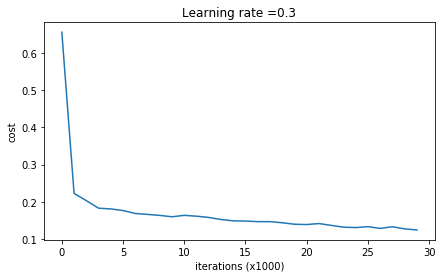

Accuracy on the training set: 0.9478672985781991
Accuracy on the test set: 0.915


In [5]:
parameters = model(train_X, train_Y)

pred_train = predict(train_X, parameters)
accuracy = np.mean(pred_train == train_Y)
print("Accuracy on the training set: {}".format(accuracy))

pred_test = predict(test_X, parameters)
accuracy = np.mean(pred_test == test_Y)
print("Accuracy on the test set: {}".format(accuracy))

This is the **baseline model** (you will observe the impact of regularization on this model).

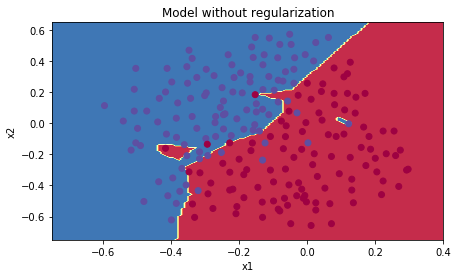

In [6]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict(x.T, parameters), train_X, train_Y)

The non-regularized model is obviously overfitting the training set. It is fitting the noisy points!

## 2.2 - L2 Regularization

In [7]:
def compute_cost_with_regularization(AL, Y, parameters, lambd):
    """
    Implement the cost function with L2 regularization. See formula (2) above.
    
    Arguments:
    A3 -- post-activation, output of forward propagation, of shape (output size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    parameters -- python dictionary containing parameters of the model
    
    Returns:
    cost - value of the regularized loss function (formula (2))
    """
    m = Y.shape[1]
    cross_entropy_cost = compute_cost(AL, Y) # This gives you the cross-entropy part of the cost
    
    L = len(parameters)//2
    reg = 0
    for l in range(1, L + 1):
        reg += np.sum(np.square(parameters["W" + str(l)]))
    
    return cross_entropy_cost + reg/2/m*lambd

In [8]:
def backward_propagation_with_regularization(X, Y, cache, lambd):
    """
    Implements the backward propagation of our baseline model to which we added an L2 regularization.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation()
    lambd -- regularization hyperparameter, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    # retrieve parameters
    W, b, A, Z = cache
    # no of layers
    L = len(W) 
    # no of samples
    m = X.shape[1]
    dZ = {}; dA = {}
    dW = {}; db = {}
    
    
    
    for l in range(L, 0, -1):
        if l == L:
            dZ[l] = (A[l] - Y)/m
        else:
            dA[l] = np.dot(W[l+1].T, dZ[l+1])
            dZ[l] = dA[l] * (A[l] > 0)
        dW[l] = np.dot(dZ[l], A[l-1].T) + lambd * W[l]/m
        db[l] = np.sum(dZ[l], axis = 1, keepdims = True)
         
    grads = (dW, db)
    return grads

Cost after iteration 0: 0.6974484493131264
Cost after iteration 10000: 0.2684918873282238
Cost after iteration 20000: 0.26809163371273015


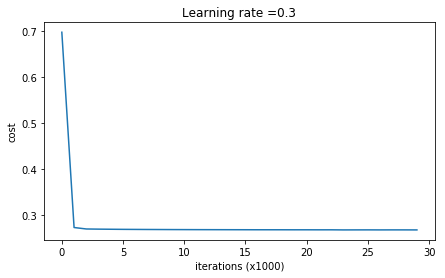

Accuracy on the training set: 0.9383886255924171
Accuracy on the test set: 0.93


In [9]:
parameters = model(train_X, train_Y, lambd = 0.7)
pred_train = predict(train_X, parameters)
accuracy = np.mean(pred_train == train_Y)
print("Accuracy on the training set: {}".format(accuracy))

pred_test = predict(test_X, parameters)
accuracy = np.mean(pred_test == test_Y)
print("Accuracy on the test set: {}".format(accuracy))

The test set accuracy increased to 93%. 
You are not overfitting the training data anymore. 

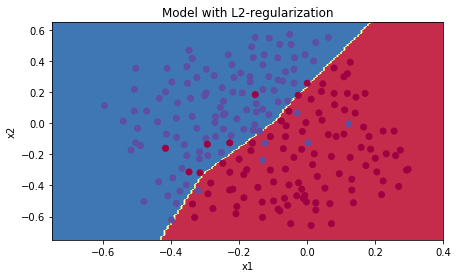

In [10]:
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict(x.T, parameters), train_X, train_Y)

<font color='blue'>
**Takeaways**:
- The value of $\lambda$ is a hyperparameter that you can tune using a dev set.
- Weights end up smaller ("weight decay"): weights are pushed to smaller values.
- L2 regularization makes your decision boundary smoother. If $\lambda$ is too large, it is also possible to "oversmooth", resulting in a model with high bias.

<font color='black'>
**What is L2-regularization actually doing?**:

L2-regularization relies on the assumption that a model with small weights is simpler than a model with large weights. Thus, by penalizing the square values of the weights in the cost function you drive all the weights to smaller values. It becomes too costly for the cost to have large weights! This leads to a smoother model in which the output changes more slowly as the input changes. 


## 2.2 - Dropout

- **Dropout** is a widely used regularization technique that is specific to deep learning. **It randomly shuts down some neurons in each iteration.**

In [11]:
def forward_propagation_with_dropout(X, parameters, keep_prob):
    """
    Implements the forward propagation: LINEAR -> RELU + DROPOUT -> LINEAR -> RELU + DROPOUT -> LINEAR -> SIGMOID.
    
    Arguments:
    X -- input dataset, of shape (2, number of examples)
    parameters -- python dictionary containing your parameters rop-out, scalar
    
    Returns:
    A3 -- last activation value, output of the forward propagation, of shape (1,1)
    cache -- tuple, information stored for computing the backward propagation
    """    
    np.random.seed(1)
    A = {}; Z = {}; D = {}; W = {}; b = {}
    A[0] = X
    
    # no of layers
    L = len(parameters)//2
    
    # (LINEAR -> RELU)*(L-1) -> LINEAR -> SIGMOID
    for l in range(1, L + 1):
        W[l] = parameters["W" + str(l)]
        b[l] = parameters["b" + str(l)]
        Z[l] = np.dot(W[l], A[l-1]) + b[l]
        if l == L:
            A[l] = sigmoid(Z[l])
        else:
            A[l] = relu(Z[l])
            D[l] = (np.random.uniform(low = 0, high = 1, size = A[l].shape) < keep_prob)
            A[l] *= D[l]
            A[l] /=keep_prob            
    cache = (W, b, A, Z, D)
    return A[L], cache

In [12]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    """
    Implements the backward propagation of our baseline model to which we added dropout.
    
    Arguments:
    X -- input dataset, of shape (2, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation_with_dropout()
    keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """ 
    # retrieve parameters
    W, b, A, Z, D = cache
    # no of layers
    L = len(W)
    # no of samples
    m = X.shape[1]
    dZ = {}; dA = {}
    dW = {}; db = {}       
    for l in range(L, 0, -1):
        if l == L:
            dZ[l] = (A[l] - Y)/m
        else:
            dA[l] = np.dot(W[l+1].T, dZ[l+1])
            dA[l] *= D[l]
            dA[l] /= keep_prob
            dZ[l] = dA[l] * (A[l] > 0)
        dW[l] = np.dot(dZ[l], A[l-1].T)
        db[l] = np.sum(dZ[l], axis = 1, keepdims = True)
         
    grads = (dW, db)
    return grads

Cost after iteration 0: 0.6543912405149824


C:\Users\zhuxm\OneDrive\coursenotes\NeuralNetworks\04-Practical-Aspects-of-Deep-Learning\regularization\reg_utils.py:126: RuntimeWarning: divide by zero encountered in log
  return - np.nansum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))/Y.shape[1]
C:\Users\zhuxm\OneDrive\coursenotes\NeuralNetworks\04-Practical-Aspects-of-Deep-Learning\regularization\reg_utils.py:126: RuntimeWarning: invalid value encountered in multiply
  return - np.nansum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))/Y.shape[1]


Cost after iteration 10000: 0.0610169865749056
Cost after iteration 20000: 0.06058243579851311


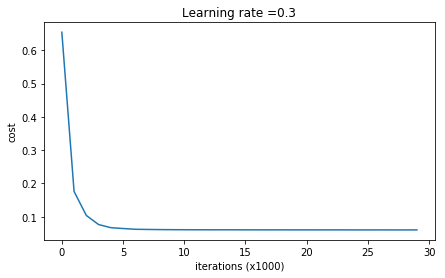

Accuracy on the training set: 0.9289099526066351
Accuracy on the test set: 0.95


In [13]:
parameters = model(train_X, train_Y, keep_prob = 0.86, learning_rate = 0.3)
pred_train = predict(train_X, parameters)
accuracy = np.mean(pred_train == train_Y)
print("Accuracy on the training set: {}".format(accuracy))

pred_test = predict(test_X, parameters)
accuracy = np.mean(pred_test == test_Y)
print("Accuracy on the test set: {}".format(accuracy))

The test accuracy has increased again (to 95%)! Your model is not overfitting the training set and does a great job on the test set.

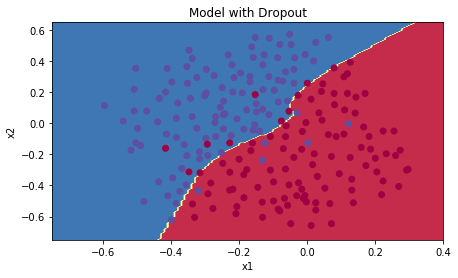

In [14]:
plt.title("Model with Dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict(x.T, parameters), train_X, train_Y)

<font color='blue'>
**Takeaways**
- Dropout is a regularization technique.
- You only use dropout during training. Don't use dropout during test time.
- Apply dropout both during forward and backward propagation.
- During training time, divide each dropout layer by keep_prob to keep the same expected value for the activations. For example, if keep_prob is 0.5, then we will on average shut down half the nodes, so the output will be scaled by 0.5 since only the remaining half are contributing to the solution. Dividing by 0.5 is equivalent to multiplying by 2. Hence, the output now has the same expected value. 